# Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import parse
import multiprocessing
from bs4 import BeautifulSoup # Text Cleaning
import re, string # Regular Expressions, String
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer # for word stemming
from nltk.stem import WordNetLemmatizer # for word lemmatization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras_preprocessing.sequence import pad_sequences
import unicodedata
import html
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

%matplotlib inline

ModuleNotFoundError: ignored

In [ ]:
!pip install parse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=206be6fc4a93794f59b61685e49a05892b328a4283d893ebd461e3cd28936862
  Stored in directory: /root/.cache/pip/wheels/e5/33/1f/68392720485b3ecf125a69e700baaab7624616deedea2fa6e2
Successfully built parse


### Creating a function to get all the app names

In [ ]:
path = r'./data'
def getAppNames(path):
    list_of_files = os.listdir(path)
    app_names = []
    for file in list_of_files:
        name = parse.parse('submission_{}.csv',file)
        app_names.append(str(name)[10:-7])
    
    return app_names

appNames = getAppNames(path)
appNames

['candidate', 'jobget', 'jobseeker', 'jobswipe', 'mobile']

##### To create the final_submission.csv file, building a data pipeline function that takes path and app names as input and returns the final dataframe.

In [ ]:
def creating_df(path, appNames):
    dfs = []
    for file in os.listdir(path):
        print("Reading "+file)
        data = pd.read_csv(path+'/'+ file)
        df = pd.DataFrame(data)
        print("Current Data Frame shape ")
        print(df.shape)
        df['appName'] = appNames[os.listdir(path).index(file)]
        dfs.append(df)
    print("Total Files found: ", len(dfs))
    final_df = pd.DataFrame()
    for i in range(len(dfs)):
        final_df = pd.concat([final_df, dfs[i]], axis=0)
        
    return final_df
    
final_df = creating_df(path, appNames)
final_df

Reading submission_candidate.csv
Current Data Frame shape 
(143, 10)
Reading submission_jobget.csv
Current Data Frame shape 
(3374, 10)
Reading submission_jobseeker.csv
Current Data Frame shape 
(8909, 10)
Reading submission_jobswipe.csv
Current Data Frame shape 
(703, 10)
Reading submission_mobile.csv
Current Data Frame shape 
(105, 10)
Total Files found:  5


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate
...,...,...,...,...,...,...,...,...,...,...,...
100,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,2021-11-14 16:15:49,NaN,NaN,mobile
101,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile
102,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile
103,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile


In [ ]:
final_df.to_csv(path+'/'+'final_submission.csv', index=False) 
print("Final Submission File SAVED!")
print("Final File Shape: ", final_df.shape)
final_df.head()

Final Submission File SAVED!
Final File Shape:  (13234, 11)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate


In [ ]:
#creating a nested condition to insert values according to the rating
# if score equal to 3 then neutral
# if score greater than 3 then positive
# if score less than 3 then negative
final_df['sentiment'] = np.where(final_df['score'] == 3, 'neutral', np.where(final_df['score'] <3, 'negative', np.where(final_df['score'] >3, 'positive', np.nan)))
final_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,negative
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,negative
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,negative
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,negative
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,negative
...,...,...,...,...,...,...,...,...,...,...,...,...
100,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,2021-11-14 16:15:49,NaN,NaN,mobile,positive
101,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile,positive
102,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile,positive
103,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile,positive


In [ ]:
#Checking if any row has null values
final_df['sentiment'].isnull().values.sum() 

0

# Data Preprocessing

In [ ]:
# Creating a cleaning function

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #     # strip html
    #     soup = BeautifulSoup(text, 'html.parser')
    #     text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13234 entries, 0 to 104
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13234 non-null  object
 1   userName              13234 non-null  object
 2   userImage             13234 non-null  object
 3   content               13225 non-null  object
 4   score                 13234 non-null  int64 
 5   thumbsUpCount         13234 non-null  int64 
 6   reviewCreatedVersion  10497 non-null  object
 7   at                    13234 non-null  object
 8   replyContent          3379 non-null   object
 9   repliedAt             3379 non-null   object
 10  appName               13234 non-null  object
 11  sentiment             13234 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.3+ MB


In [ ]:
final_df = final_df[final_df['content'].notna()]
final_df.shape

(13225, 12)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13225 entries, 0 to 104
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              13225 non-null  object
 1   userName              13225 non-null  object
 2   userImage             13225 non-null  object
 3   content               13225 non-null  object
 4   score                 13225 non-null  int64 
 5   thumbsUpCount         13225 non-null  int64 
 6   reviewCreatedVersion  10491 non-null  object
 7   at                    13225 non-null  object
 8   replyContent          3378 non-null   object
 9   repliedAt             3378 non-null   object
 10  appName               13225 non-null  object
 11  sentiment             13225 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.3+ MB


In [ ]:
final_df = final_df.drop(['reviewCreatedVersion', 'replyContent', 'repliedAt'], axis=1)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13225 entries, 0 to 104
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       13225 non-null  object
 1   userName       13225 non-null  object
 2   userImage      13225 non-null  object
 3   content        13225 non-null  object
 4   score          13225 non-null  int64 
 5   thumbsUpCount  13225 non-null  int64 
 6   at             13225 non-null  object
 7   appName        13225 non-null  object
 8   sentiment      13225 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.0+ MB


In [ ]:
clean_df = final_df.copy()
clean_df['content'] = final_df['content'].apply(clean_text)

In [ ]:
from keybert import KeyBERT

In [ ]:
keyModel = KeyBERT()

In [ ]:
clean_high_rated_df = pd.concat([clean_df[clean_df['score'] == 4], clean_df[clean_df['score'] == 5]], axis=0)
clean_high_rated_df

,reviewId,userName,userImage,content,score,thumbsUpCount,at,appName,sentiment
6,098e9eef-cd64-41d4-b9e4-a46fc1356dda,Kadar Harris,https://play-lh.googleusercontent.com/a/AGNmyx...,great,4,0,2022-03-25 23:27:33,candidate,positive
31,0b3d424c-edd3-4d76-bce1-d3238ed7d35d,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,ok,4,0,2020-01-31 22:57:34,candidate,positive
32,a2f921b2-049e-4e4a-afff-d44a0ead6cee,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,great app think need update google cause googl...,4,0,2019-11-07 03:53:56,candidate,positive
56,1ca21a55-95af-45b5-a823-9f55fb86426c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,glitchy profile update annoy position choose l...,4,0,2019-09-17 21:29:28,candidate,positive
59,dccb8488-14bc-4af7-b3df-59efd4df8752,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,excellen app,4,0,2019-08-08 19:40:28,candidate,positive
...,...,...,...,...,...,...,...,...,...
100,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,rather tasty,5,7,2021-11-14 16:15:49,mobile,positive
101,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,make happen sake course work together make sur...,5,9,2021-11-13 03:00:17,mobile,positive
102,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,best,5,5,2021-11-03 15:02:20,mobile,positive
103,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,nice app,5,8,2021-10-22 06:44:09,mobile,positive


In [ ]:
doc = ''
for comnt in clean_high_rated_df['content']:
    doc += comnt+'. '
doc

'great. ok. great app think need update google cause google cant find place work work experience recognize app wont let send application job application app basically useless. glitchy profile update annoy position choose list thousand cant enter end date job unless use website also enter job sometimes address show name business great apply though. excellen app. find job fine guy need fix bug cant set interview app doesnt work correctly. bug fix great one best apps hospitality work wish job queen ny would start use app. nice app. good. great big city answer hubdreds list first week schedule dozen interview first month. wish could still view ad apply. great. great far. beautiful app guess still develop doesnt message capability available full site absolutely love site app. think app much better actually earn money. easy use. help find many job would never think area good pay. app really good find good job. far would say one thorough helpful job search apps run across far give update use 

In [ ]:
three_word_KW = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,3), stop_words=None)
print(three_word_KW)

[('job apps good', 0.7106), ('job apps great', 0.6999), ('job app better', 0.6875), ('better job apps', 0.6851), ('suggest app jobemployment', 0.6837)]


In [ ]:
five_word_KW = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,5), stop_words=None)
print(five_word_KW)

[('find job good great app', 0.7481), ('find job need excellent app', 0.7472), ('good app find job good', 0.7443), ('good app opportunity get job', 0.744), ('find job good app great', 0.7421)]


In [ ]:
KW_using_mmr = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,1), stop_words='english', use_mmr=True, diversity=0.7)
print(KW_using_mmr)

[('jobsearching', 0.4604), ('applay', 0.2088), ('confidence', 0.108), ('ovfyqqqefywfqwwfjsowakmzmsjzmzjsjssjissijssjsjjsjx', 0.1031), ('coronavirus', 0.0065)]


In [ ]:
KW_using_maxsum = keyModel.extract_keywords(doc, keyphrase_ngram_range=(1,1), stop_words='english', use_maxsum=True, nr_candidates=20, top_n=5)
print(KW_using_maxsum)

[('jobswip', 0.373), ('appsuper', 0.3996), ('jobemployment', 0.402), ('jobsearch', 0.4356), ('apps', 0.4412)]


# Classifying reviews with positive and negative experiences 

In [ ]:
df = pd.read_csv('./data/final_submission.csv')
df['sentiment'] = np.where(df['score'] > 2.5, 1, 0)
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,0
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,0
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,0
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,0
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13229,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,2021-11-14 16:15:49,NaN,NaN,mobile,1
13230,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile,1
13231,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile,1
13232,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile,1


In [ ]:
df = df[df['content'].notna()]
df.shape

(13225, 12)

In [ ]:
df.content[10000]

'Great'

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores(df.content[10000])

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}

In [ ]:
sia.polarity_scores(df.content[0])

{'neg': 0.159, 'neu': 0.775, 'pos': 0.066, 'compound': -0.5572}

In [ ]:
df = df.reset_index()

In [ ]:
# Running the polarity score throughout the dataframe
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['content']
    myid = i
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/13225 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders

,neg,neu,pos,compound
0,0.159,0.775,0.066,-0.5572
1,0.000,1.000,0.000,0.0000
2,0.177,0.823,0.000,-0.6249
3,0.134,0.866,0.000,-0.7546
4,0.000,1.000,0.000,0.0000
...,...,...,...,...
13220,0.000,1.000,0.000,0.0000
13221,0.039,0.854,0.107,0.7650
13222,0.000,0.192,0.808,0.6369
13223,0.000,0.263,0.737,0.4215


In [ ]:
sum(vaders.neg)/len(vaders.neg)

0.030194404536861955

In [ ]:
sum(vaders.pos)/len(vaders.neg)

0.36659500945179985

In [ ]:
sum(vaders.neu)/len(vaders.neg)

0.6005648393194742

In [ ]:
vaders = pd.DataFrame(res).T
vaders = pd.concat([vaders, df], axis=1)

In [ ]:
vaders.head()

,neg,neu,pos,compound,index,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,0.159,0.775,0.066,-0.5572,0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,0
1,0.000,1.000,0.000,0.0000,1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,0
2,0.177,0.823,0.000,-0.6249,2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,0
3,0.134,0.866,0.000,-0.7546,3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,0
4,0.000,1.000,0.000,0.0000,4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,0


# Plot Vader Results

Text(0.5, 1.0, 'Compound Score by App Rating')

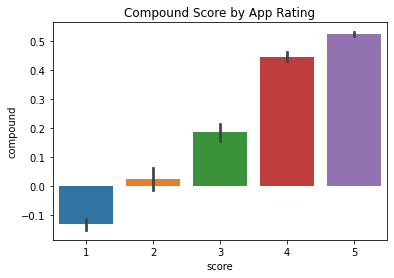

In [ ]:
ax = sns.barplot(data=vaders, x='score', y='compound')
ax.set_title('Compound Score by App Rating')

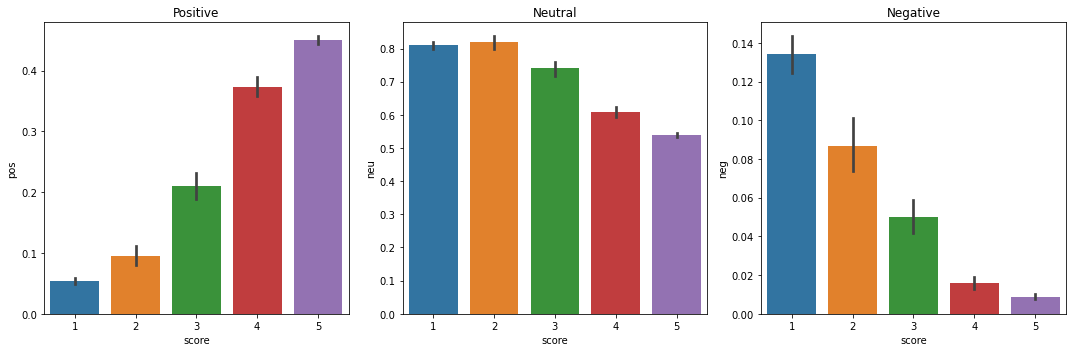

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
sns.barplot(data=vaders, x='score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='score', y='neg', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
def polarity_scores_roberta(example): # Creating a function for evaluating roberta model
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [ ]:
res = {} # Empty dictionary
for i, row in tqdm(df.iterrows(), total=len(df)): # Looping through all the content
    try:
        text = row['content'] # getting the text
        myid = i # getting the index
        vader_result = sia.polarity_scores(text) # getting the polarity scores
        vader_result_rename = {}
        for key, value in vader_result.items(): # looping through all the outputs
            vader_result_rename[f"vader_{key}"] = value # Renaming the model for vader
        roberta_result = polarity_scores_roberta(text) # evaluating the text using roberta model
        both = {**vader_result, **roberta_result} # saving both values
        res[myid] = both
    except RuntimeError: # catching exceptions for the comments which are too long
        print(f'Broke for id {myid}')

  0%|          | 0/13225 [00:00<?, ?it/s]

Broke for id 3395


In [ ]:
results_df = pd.DataFrame(res).T
results_df = pd.concat([results_df, vaders.drop(['pos', 'neg', 'neu', 'compound'], axis=1)], axis=1)
results_df

,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,index,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appName,sentiment
0,0.159,0.775,0.066,-0.5572,0.742227,0.212321,0.045452,0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,2023-02-08 19:41:20,NaN,NaN,candidate,0
1,0.000,1.000,0.000,0.0000,0.300037,0.540561,0.159402,1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,2022-09-26 04:18:21,NaN,NaN,candidate,0
2,0.177,0.823,0.000,-0.6249,0.984752,0.012806,0.002442,2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,2022-07-20 08:11:02,NaN,NaN,candidate,0
3,0.134,0.866,0.000,-0.7546,0.959680,0.036837,0.003484,3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,2022-06-27 23:48:52,NaN,NaN,candidate,0
4,0.000,1.000,0.000,0.0000,0.563433,0.402357,0.034210,4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,2022-05-16 22:59:26,NaN,NaN,candidate,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13221,0.039,0.854,0.107,0.7650,0.042778,0.371820,0.585402,13230,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,2021-11-13 03:00:17,NaN,NaN,mobile,1
13222,0.000,0.192,0.808,0.6369,0.012973,0.121171,0.865856,13231,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,2021-11-03 15:02:20,NaN,NaN,mobile,1
13223,0.000,0.263,0.737,0.4215,0.012006,0.084710,0.903284,13232,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,2021-10-22 06:44:09,NaN,NaN,mobile,1
13224,0.000,0.772,0.228,0.8122,0.001107,0.012334,0.986559,13233,46d05a26-97a1-4336-a274-521711f62960,Aaron Brodrik,https://play-lh.googleusercontent.com/a-/ACB-R...,Been using the website for awhile and it's the...,5,13,1.0.1.364,2021-09-16 23:34:32,NaN,NaN,mobile,1


In [ ]:
sum(results_df.roberta_neg)/len(results_df.roberta_neg)

nan

In [ ]:
results_df = results_df.drop([3403], axis=0)

In [ ]:
results_df.columns

Index(['neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'index', 'reviewId', 'userName', 'userImage', 'content',
       'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appName', 'sentiment'],
      dtype='object')

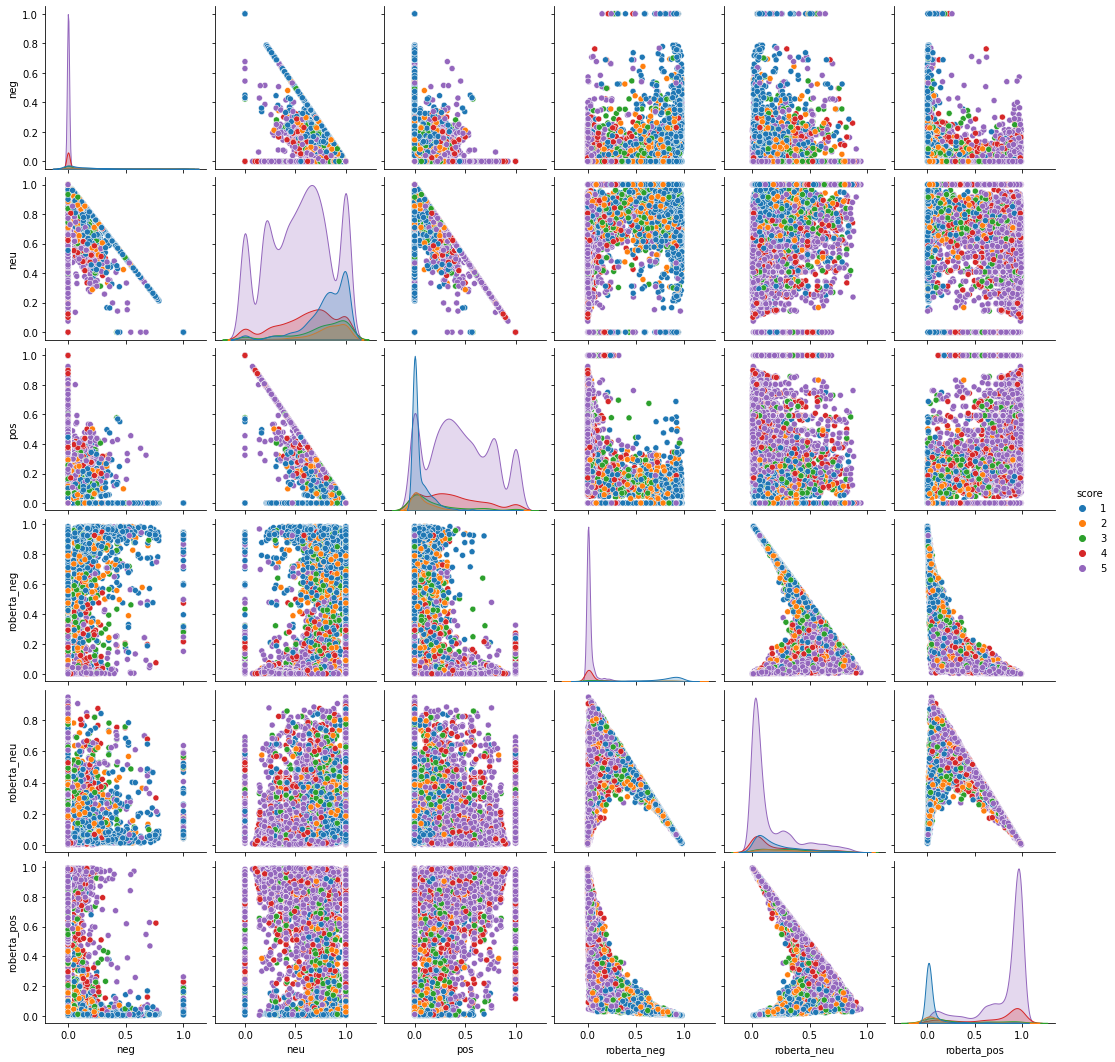

In [ ]:
pairplot = sns.pairplot(data=results_df, 
            vars=['neg', 'neu', 'pos', 
                 'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='score',
            palette='tab10')
pairplot.savefig('./results/vader_vs_roberta.jpg')
plt.show()

# Comparing the results from the two models:
- The roberta model had a better result
- The vader model showed a scattered result
- In the roberta model majority of the positive comments were rated 5, but the model also found a few 1 rated model as positive
- Majority of the neutral components of the comments were found in the 5 rated comments

In [ ]:
df = df.drop(['at', 'replyContent', 'repliedAt'], axis=1)

In [ ]:
df

,index,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,appName,sentiment
0,0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,Found great bar jobs on here in the past but n...,1,0,3.2.11,candidate,0
1,1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,Try to upload resume and it just stays uploading!,2,0,3.2.6,candidate,0
2,2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,"This is one of the worst apps I've ever used,w...",1,0,NaN,candidate,0
3,3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,If I cant upload a resume because for whatever...,1,1,3.2.5,candidate,0
4,4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,It's not logging in,1,0,3.2.3,candidate,0
...,...,...,...,...,...,...,...,...,...,...
13220,13229,45d71edd-c573-4bc2-a219-ac7e31cb90ad,Alan J,https://play-lh.googleusercontent.com/a-/ACB-R...,Rather tasty,5,7,1.0.1.364,mobile,1
13221,13230,6d98a697-0814-46f1-b8b8-fbbcb3f9f3b3,Tracy Nguyen,https://play-lh.googleusercontent.com/a-/ACB-R...,I am about to do it myself to make it happen a...,5,9,NaN,mobile,1
13222,13231,8bbd9f45-73b4-42e0-8057-d4fc362c121a,Jeremy Yatchmenoff,https://play-lh.googleusercontent.com/a/AGNmyx...,The best,5,5,1.0.1.364,mobile,1
13223,13232,6a62c0a3-c52d-4900-9fd4-32a10c277afe,David Shaw,https://play-lh.googleusercontent.com/a-/ACB-R...,Nice app,5,8,1.0.1.364,mobile,1


# Preprocessing 
- Casing
- Noise Removal
- Tokenization
- Stopword Removal
- Text Normalization (Stemming and Lemmatization)

In [ ]:
# Creating a cleaning function

# set of stopwords to be removed from text
stop = set(stopwords.words('english'))

# update stopwords to have punctuation too
stop.update(list(string.punctuation))

def clean_text(text):
    
    # Remove unwanted html characters
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
    'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
    '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
    ' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(x1))
    
    # remove non-ascii characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #     # strip html
    #     soup = BeautifulSoup(text, 'html.parser')
    #     text = soup.get_text()
    
    # remove between square brackets
    text = re.sub('\[[^]]*\]', '', text)
    
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # remove twitter tags
    text = text.replace("@", "")
    
    # remove hashtags
    text = text.replace("#", "")
    
    # remove all non-alphabetic characters
    text = re.sub(r'[^a-zA-Z ]', '', text)
    
    # remove stopwords from text
    final_text = []
    for word in text.split():
        if word.strip().lower() not in stop:
            final_text.append(word.strip().lower())
    
    text = " ".join(final_text)
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()    
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = " ".join([lemmatizer.lemmatize(word, pos = 'v') for word in text.split()])
    
    # replace all numbers with "num"
    text = re.sub("\d", "num", text)
    
    return text.lower()

In [ ]:
clean_text(df.content[0])

'find great bar job past new updat plagu phish spam job list doesnt allow upload new resum sad see state app'

In [ ]:
df.content[0]

'found great bar job past new updat plagu phish spam job list doesnt allow upload new resum sad see state app'

In [ ]:
df['content'] = df['content'].apply(clean_text)

# Vectorizing Tokens

In [ ]:
X = df.content # Input data
y = df.sentiment # Targetted class

In [ ]:
X

0        find great bar job past new updat plagu phish ...
1                             tri upload resum stay upload
2        one bad app ive ever usedwil never appli job u...
3        cant upload resum whatev reason stay stick loa...
4                                                      log
                               ...                        
13220                                         rather tasti
13221    make happen sake cours work togeth make sure m...
13222                                                 best
13223                                             nice app
13224    use websit awhil best place find hospit job ar...
Name: content, Length: 13225, dtype: object

In [ ]:
corpus = []
corpus = df.content.copy()
corpus # creating a corpus using the comments from the data frame

0        find great bar job past new updat plagu phish ...
1                             tri upload resum stay upload
2        one bad app ive ever usedwil never appli job u...
3        cant upload resum whatev reason stay stick loa...
4                                                      log
                               ...                        
13220                                         rather tasti
13221    make happen sake cours work togeth make sure m...
13222                                                 best
13223                                             nice app
13224    use websit awhil best place find hospit job ar...
Name: content, Length: 13225, dtype: object

In [ ]:
from keras.preprocessing.text import Tokenizer # importing tokenizer
tokenizer = Tokenizer(oov_token='<nothing>') # creating tokenizer instance and, labeling out of vocabulary words as <nothing>

In [ ]:
tokenizer.fit_on_texts(corpus) # Fitting the corpus in the tokenizer to generate tokens for each of the comments

In [ ]:
max(tokenizer.word_index) # Looking for the word that occured the most

'zzz'

In [ ]:
tokenizer.word_counts

OrderedDict([('find', 1691),
             ('great', 2029),
             ('bar', 11),
             ('job', 6537),
             ('past', 66),
             ('new', 255),
             ('updat', 204),
             ('plagu', 1),
             ('phish', 1),
             ('spam', 54),
             ('list', 247),
             ('doesnt', 276),
             ('allow', 91),
             ('upload', 119),
             ('resum', 274),
             ('sad', 7),
             ('see', 255),
             ('state', 62),
             ('app', 5646),
             ('tri', 440),
             ('stay', 38),
             ('one', 543),
             ('bad', 90),
             ('ive', 456),
             ('ever', 180),
             ('usedwil', 1),
             ('never', 218),
             ('appli', 1115),
             ('use', 1928),
             ('cant', 342),
             ('whatev', 17),
             ('reason', 45),
             ('stick', 25),
             ('load', 86),
             ('screen', 64),
             ('press',

'z'

In [ ]:
len(tokenizer.word_counts) # Counting the number of different words

4934

In [ ]:
tokenizer.document_count # Counting the number of comments which were converter into tokens

13225

In [ ]:
sequences = tokenizer.texts_to_sequences(corpusus)
sequences 

[[9,
  5,
  739,
  2,
  227,
  63,
  85,
  2271,
  2272,
  265,
  2,
  68,
  56,
  174,
  145,
  63,
  57,
  925,
  64,
  239,
  3],
 [31, 145, 57, 348, 145],
 [22, 175, 3, 27, 101, 2273, 79, 12, 2, 6, 3],
 [44,
  145,
  57,
  587,
  298,
  348,
  456,
  182,
  233,
  707,
  145,
  3,
  588,
  21,
  31,
  4,
  2,
  44,
  162,
  16,
  298,
  21,
  1219,
  299,
  1220,
  4,
  2],
 [198],
 [11],
 [5],
 [3, 56, 28, 13],
 [44, 28, 97, 3],
 [355, 175, 3, 6, 202],
 [44, 28, 481],
 [3,
  56,
  182,
  216,
  228,
  3,
  339,
  481,
  1403,
  565,
  199,
  340,
  3,
  105,
  13,
  383,
  3,
  875],
 [3, 2274, 106, 2275, 166, 68],
 [122,
  14,
  2,
  9,
  3,
  2,
  1404,
  72,
  123,
  284,
  226,
  195,
  123,
  394,
  44,
  220,
  129,
  78,
  2,
  69,
  290,
  995,
  2276,
  3],
 [6, 5, 3, 6, 17, 4, 2, 62, 2, 1405, 73, 42, 194],
 [44,
  85,
  57,
  159,
  20,
  1406,
  77,
  28,
  708,
  382,
  68,
  1407,
  1407,
  6,
  3,
  383,
  227,
  268,
  779,
  110,
  94,
  119,
  178],
 [199, 325],
 

In [ ]:
sequences = pad_sequences(sequences,padding='post') # padding the sentences for a symmetric matrix

In [ ]:
sequences

array([[  9,   5, 739, ...,   0,   0,   0],
       [ 31, 145,  57, ...,   0,   0,   0],
       [ 22, 175,   3, ...,   0,   0,   0],
       ...,
       [ 30,   0,   0, ...,   0,   0,   0],
       [ 76,   3,   0, ...,   0,   0,   0],
       [  6, 105, 816, ...,   0,   0,   0]])

In [ ]:
sequences[0]

array([   9,    5,  739,    2,  227,   63,   85, 2271, 2272,  265,    2,
         68,   56,  174,  145,   63,   57,  925,   64,  239,    3,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])

In [ ]:
len(sequences[0]) # The input lenth of the model

78

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size=0.2, random_state=0) #Splitting the data into train and test

In [ ]:
print("X_train: ", X_train.shape)
print("X_train: ", X_test.shape)
print("X_train: ", y_train.shape)
print("X_train: ", y_test.shape)

X_train:  (10580, 78)
X_train:  (2645, 78)
X_train:  (10580,)
X_train:  (2645,)


# Model

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional


## Creating model
embedding_vector_features = 40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=78))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 78, 40)            4000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              112800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 4,113,001
Trainable params: 4,113,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
### Finally Training
model1.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=15, batch_size=256)

Epoch 1/15
42/42 [==============================] - 18s 435ms/step - loss: 0.3151 - accuracy: 0.8689 - val_loss: 0.2444 - val_accuracy: 0.9009
Epoch 2/15
42/42 [==============================] - 18s 437ms/step - loss: 0.2026 - accuracy: 0.9204 - val_loss: 0.2153 - val_accuracy: 0.9168
Epoch 3/15
42/42 [==============================] - 18s 429ms/step - loss: 0.1863 - accuracy: 0.9316 - val_loss: 0.2048 - val_accuracy: 0.9221
Epoch 4/15
42/42 [==============================] - 18s 430ms/step - loss: 0.1462 - accuracy: 0.9432 - val_loss: 0.2145 - val_accuracy: 0.9240
Epoch 5/15
42/42 [==============================] - 18s 430ms/step - loss: 0.1424 - accuracy: 0.9491 - val_loss: 0.2176 - val_accuracy: 0.9225
Epoch 6/15
42/42 [==============================] - 18s 430ms/step - loss: 0.1193 - accuracy: 0.9568 - val_loss: 0.2376 - val_accuracy: 0.9248
Epoch 7/15
42/42 [==============================] - 18s 435ms/step - loss: 0.1080 - accuracy: 0.9631 - val_loss: 0.2502 - val_accuracy: 0.9206

In [ ]:
model1.save('LSTM_APPREVIEW_CLASSIFIER.h5') #Saving the model

In [ ]:
# Test input
a = ["Can't find a single job! One of the worst apps ever!"]

# Creating a function to test on sentences
def predicting_sentiment(sentence_list):
    a = tokenizer.texts_to_sequences(sentence_list)
    a = np.array(a)
    a = pad_sequences(a, padding='post', maxlen = 78)
    a = a.reshape((a.shape[0], a.shape[1], 1))
    prediction = model1.predict(a)
    if prediction > 0.5:
        print("The sentiment is: Positive", prediction)
    else:
        print("The sentiment is: Negative", prediction)

In [ ]:
predicting_sentiment(a)

1/1 [==============================] - 0s 101ms/step
The sentiment is: Negative [[0.22031339]]


In [ ]:
# Reason for apps failing

In [ ]:
low_rated_df = clean_df[clean_df['score'] < 2.5]
low_rated_df

,reviewId,userName,userImage,content,score,thumbsUpCount,at,appName,sentiment
0,d505016e-3b37-4ba2-97cf-16c9ef54f84c,David Webster,https://play-lh.googleusercontent.com/a-/ACB-R...,find great bar job past new update plague phis...,1,0,2023-02-08 19:41:20,candidate,negative
1,eae5efd4-26eb-469d-b793-f9689510ebbf,Joshua Espinoza,https://play-lh.googleusercontent.com/a/AGNmyx...,try upload resume stay upload,2,0,2022-09-26 04:18:21,candidate,negative
2,c7156674-d0bf-497e-924e-07802e9cda9d,Robert Basom,https://play-lh.googleusercontent.com/a-/ACB-R...,one worst apps ive ever usedwill never apply j...,1,0,2022-07-20 08:11:02,candidate,negative
3,520a4e2f-d352-4fe4-a63b-ceea058663bf,Daniel DLS,https://play-lh.googleusercontent.com/a-/ACB-R...,cant upload resume whatever reason stay stick ...,1,1,2022-06-27 23:48:52,candidate,negative
4,254d1260-7a30-4ae1-8c68-53f597c3c84c,Morris Kagunya,https://play-lh.googleusercontent.com/a-/ACB-R...,log,1,0,2022-05-16 22:59:26,candidate,negative
...,...,...,...,...,...,...,...,...,...
83,3e0b6646-ae8b-4d57-8974-c8395771f897,Alisia Thursby,https://play-lh.googleusercontent.com/a-/ACB-R...,underused use old job list available app need ...,2,5,2022-04-26 02:23:33,mobile,negative
85,2c7e2f47-199a-4512-b6b7-fa1f647ea9a9,Kristopher Bigelow,https://play-lh.googleusercontent.com/a-/ACB-R...,help option apply shift thats suppose take pla...,1,8,2022-04-19 23:58:06,mobile,negative
87,5d4fea7a-5bfe-4261-9cce-4f6cdc4d3468,Marcus W,https://play-lh.googleusercontent.com/a/AGNmyx...,unreliable poor functionality customer support...,1,35,2022-04-13 20:32:47,mobile,negative
94,54fc0189-bbf8-4aa0-b89d-c47599527618,Chase Grohm,https://play-lh.googleusercontent.com/a/AGNmyx...,always like website app tell list area around ...,2,15,2022-01-31 00:37:51,mobile,negative


In [ ]:
LowRateddoc = ''
for comnt in low_rated_df['content']:
    LowRateddoc += comnt+'. '
LowRateddoc

'find great bar job past new update plague phishing spam job list doesnt allow upload new resume sad see state app. try upload resume stay upload. one worst apps ive ever usedwill never apply job us app. cant upload resume whatever reason stay stick load screen press upload app trust im try get job cant complete application reason im tire platform standard get job. log. app doesnt even work. cant even sign app. totally worst app use le. cant even login. app doesnt load installation choose app hit login afterwards itll crash end app website work fine app buggy. app suckscant navigate anythingcomplaints long list. seem like job find app there job inside also there account delete feature do account setup cant add company location job experience overall poorly testbeta app. use great app use time get job show job uk place dont live. cant update resume change make disappear wont even display name list null null use app fine past extremely break right hopefully fix soon. crash immediately. b

In [ ]:
KW_using_maxsum = keyModel.extract_keywords(LowRateddoc, keyphrase_ngram_range=(1,2), stop_words='english', use_maxsum=True, nr_candidates=20, top_n=5)
print(KW_using_maxsum)